**Info**: This notebook contains all the data analysis that went into the contribution attribution schemes paper.

# 1. Preamble

## 1.1 Loadouts and helper functions

Some functions we will use throughout the code so they are defined here

In [1]:
# useful viz imports
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from pprint import pprint
sns.set_style('ticks')
%matplotlib inline
from matplotlib.colors import LogNorm
clist = ['#fcfdfe','#1f77b4',  'orange', 'red']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# useful data manipulation imports
import numpy as np

## 1.2. Data

Now let's load the data we'll be analyzing. 

In [2]:
# load data
import pickle

with open('../data/contributors-data.pck', 'rb') as f:
    db = pickle.load(f)
with open('../data/metadata.pck', 'rb') as f:
    metadata = pickle.load(f)

## 1.3 Coarse-graining

The AC categories are too fine-grained for many analyzes so we'll fine-grain them

In [3]:
# coarse-craining of AC contributions:
ac_category = {"audio": "education-outreach",
                "a11y": "artifacts",
                "bug": "maintenance",
                "fix": "maintenance",   # non-native
                "blog": "education-outreach",
                "business": "lead",
                "marketing": "lead",   # non-native
                "code": "artifacts",
                "content": "education-outreach",
                "data": "artifacts",
                "doc": "artifacts",
                "docs": "artifacts",   # non-native
                "documentation": "artifacts",   # non-native
                "design": "artifacts",
                "theme": "artifacts",   # non-native
                "example": "education-outreach",
                "examples": "education-outreach",
                "eventOrganizing": "education-outreach",
                "financial": "lead",
                "fundingFinding": "lead",
                "ideas": "lead",
                "infra": "support",
                "maintenance": "maintenance",
                "mentoring": "education-outreach",
                "platform": "support",
                "plugin": "artifacts",
                "projectManagement": "lead",
                "question": "education-outreach",
                "research": "lead",
                "review": "maintenance",
                "security": "support",
                "tool": "artifacts",
                "translation": "artifacts",
                "test": "artifacts",
                "tutorial": "education-outreach",
                "talk": "education-outreach",
                "userTesting": "artifacts",
                "video": "education-outreach"}
# note I gave *some leeway* and classified non-existant categories, and alowed typos:
# typos:
#  docs -> doc -> artifact
#  documentation -> doc -> artifact
# classify:
#  theme -> design -> artifact
#  fix -> bug -> maintenance
#  marketing -> Business -> lead

Now let's create a coarsened AC taxonomy (non-standard contributions are just dropped)

In [4]:
for project in db:
    for u in db[project]:
        coarse = set()
        try:
            for c in db[project][u]['ac']:
                coarse.add(ac_category[c])
        except Exception as e:
            continue
#             print(project, u, db[project][u]['ac'], e, coarse)   # [Redacted to preserve data anonymity]
        db[project][u]['ac_coarse'] = list(coarse)

Similarly we'll coarse-grain octohatrack contributions

In [6]:
octo_category = {'IssuesEvent': 'issues',
                'MemberEvent': 'maintenance',
                'PullRequestEvent': 'code',
                'CommitCommentEvent': 'code-review',
                'DeleteEvent': "maintenance",
                'PublicEvent': "maintenance",
                'PullRequestReviewEvent': "code-review",
                'ReleaseEvent': 'maintenance',
                'GollumEvent': 'wiki-docs',
                'PushEvent': 'code',
                'CreateEvent': 'maintenance',
                'PullRequestReviewCommentEvent': 'code-review',
                'IssueCommentEvent': 'issues'}

In [7]:
for project in db:
    for u in db[project]:
        coarse = set()
        try:
            for c in db[project][u]['octo']:
                coarse.add(octo_category[c])
        except Exception as e:
            print(project, u, db[project][u]['octo'], e, coarse)
        db[project][u]['octo_coarse'] = list(coarse)

# 3. Results

## 3.1 Basic Statistics (RQ1)

### 3.1.1 The contribution barcode

In [8]:
sorted({octo_category[x] for x in octo_category})

['code', 'code-review', 'issues', 'maintenance', 'wiki-docs']

This plot is meant to capture contributions at a glance.

In [9]:

ac_category_to_idx = {'artifacts': 0,
                      'education-outreach': 1,
                      'lead': 2,
                      'maintenance': 3,
                      'support': 4}
    
    
octo_category_to_idx = {"code": 5,
                        "code-review": 6,
                        "issues": 7,
                        "maintenance": 8,
                        "wiki-docs": 9}

This next cell prepares the data. Basically we create an array of contribution-type / contributor and mark them as "on" if the pair is observed.

To make drawing easy, we mark the relationships as on with a different integer based on the system.

0. Not a contribution
1. AC contribution
2. octohatrack contribution
3. TC contribution

In [10]:
def get_contrib_mat(repo):
    # create matrix
    contrib_mat = np.zeros((5 + 5 + 1, len(db[repo])))  # 5 AC category, 5 NMC category, 1 TC category
    sorted_contribs =  sorted(db[repo], key= lambda c: len(db[repo][c]['ac']) + len(db[repo][c]['octo']), reverse=True)

    # all-contributors
    for c_idx, c in enumerate(sorted_contribs):
        for ctype in db[repo][c]['ac']:
            contrib_mat[ac_category_to_idx[ac_category[ctype]], c_idx] = 1

    # octohatrack
    for c_idx, c in enumerate(sorted_contribs):
        for ctype in db[repo][c]['octo']:
            contrib_mat[octo_category_to_idx[octo_category[ctype]], c_idx] = 2

    # top-contributors
    for c_idx, c in enumerate(sorted_contribs):
        if db[repo][c]['tc'] is True:
            contrib_mat[-1, c_idx] = 3
    return contrib_mat

def make_fig(contrib_mat):
    # using this trick to make the viz code:
    # https://stackoverflow.com/questions/9707676/defining-a-discrete-colormap-for-imshow-in-matplotlib
    plt.figure(figsize=(20,5))

    # make a color map of fixed colors
    cmap = colors.ListedColormap(clist)

    # tell imshow about color map so that only set colors are used
    img = plt.imshow(contrib_mat, interpolation='nearest',cmap=cmap)

    # do tick tricks to make grid line up
    ax = plt.gca();
    ax.set_xticks(np.arange(0, contrib_mat.shape[1], 1))
    ax.set_yticks(np.arange(0, contrib_mat.shape[0], 1))
    ax.set_xticks(np.arange(-.5, contrib_mat.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, contrib_mat.shape[0], 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    # Fix ticks
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False) 
    plt.yticks(range(11), ["AC: " + c for c in ac_category_to_idx] + ["GES: "+ c for c in octo_category_to_idx] + ["top-committer"])

    # despine
    sns.despine(left=True, bottom=True)

Make a few figures with the above code:

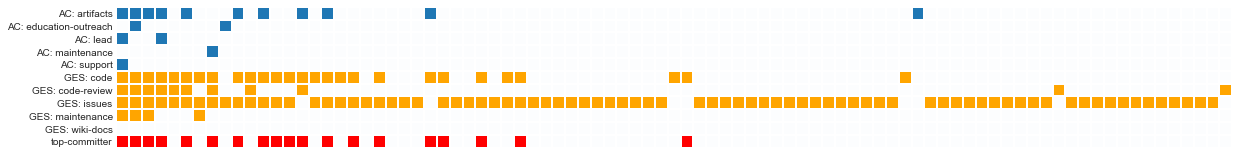

In [11]:
# all-contributors-bot
repo = ("all-contributors", "all-contributors-bot")
make_fig(get_contrib_mat(repo))


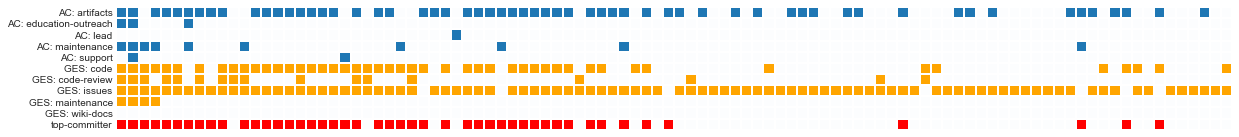

In [12]:
# top 100 all-contributors
repo = ("all-contributors", "all-contributors")
make_fig(get_contrib_mat(repo)[:, :100])


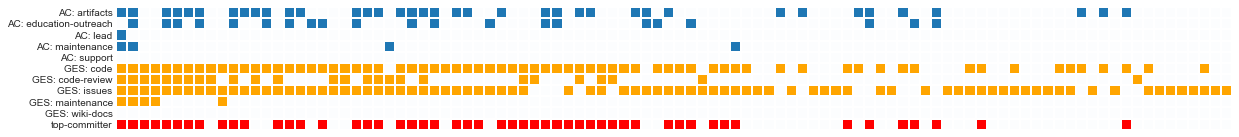

In [13]:
# top 100 all-contributors
repo = ("rust-lang", "rustlings")
make_fig(get_contrib_mat(repo)[:, :100])


### 3.1.2 Counts

In [14]:
from collections import Counter

Simple counts

In [15]:
num_contrib_AC = [len([1 for v in db[project] if len(db[project][v]['ac']) > 0]) for project in db]
num_contrib_OHR = [len([1 for v in db[project] if len(db[project][v]['octo']) > 0]) for project in db]
num_contrib_GH = [len([1 for v in db[project] if db[project][v]['tc']]) for project in db]


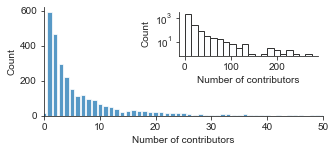

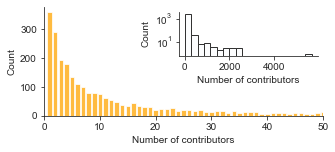

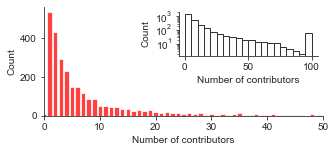

In [16]:
for data, name, color in zip([num_contrib_AC, num_contrib_OHR, num_contrib_GH],
                             ['ac', 'ohc', 'tc'],
                             clist[1:]):
    plt.figure(figsize=(5, 2))
    idx, h= zip(*Counter(data).items())
    plt.bar(idx, h, color=color, alpha=0.75)
#     plt.xticks([0,5,10,20])
    plt.xlim(0, 50)
    sns.despine()
    plt.ylabel('Count')
    plt.xlabel('Number of contributors')
    
    
    inset = inset_axes(plt.gca(), width="50%", height="40%", loc=1)
    inset.hist(data, bins=20,  facecolor=clist[0], edgecolor='#333333')
    inset.set_yscale('log')
    sns.despine()
    plt.ylabel('Count')
    plt.xlabel('Number of contributors')
    


Num project:

In [17]:
db[('aplbrain', 'substrate')]

{'hpcowley': {'ac': ['code'],
  'octo': [],
  'tc': False,
  'ac_coarse': ['artifacts'],
  'octo_coarse': []},
 'j6k4m8': {'ac': ['code'],
  'octo': ['CreateEvent',
   'DeleteEvent',
   'IssueCommentEvent',
   'IssuesEvent',
   'PullRequestEvent',
   'PushEvent'],
  'tc': True,
  'ac_coarse': ['artifacts'],
  'octo_coarse': ['code', 'maintenance', 'issues']},
 'jtpdowns': {'ac': ['code'],
  'octo': [],
  'tc': True,
  'ac_coarse': ['artifacts'],
  'octo_coarse': []}}

In [18]:
num_ac_bigger_ohr = 0
num_ac_bigger_tc = 0
num_ohr_bigger_tc = 0
norm = 0
for p in db:
    num_ac = len([1 for v in db[p] if len(db[p][v]['ac']) > 0])
    num_ohr = len([1 for v in db[p] if len(db[p][v]['octo']) > 0])
    num_tc = len([1 for v in db[p] if db[p][v]['tc']])
    norm += 1
    if num_ac > num_ohr:
        num_ac_bigger_ohr += 1
    if num_ac > num_tc:
        num_ac_bigger_tc += 1
    if num_ohr >= num_tc:
        num_ohr_bigger_tc += 1


In [19]:
print("num_ac_bigger_ohr", num_ac_bigger_ohr / norm)
print("num_ac_bigger_tc", num_ac_bigger_tc / norm)
print("1- num_ohr_bigger_tc", 1 - num_ohr_bigger_tc / norm)

num_ac_bigger_ohr 0.08143208143208143
num_ac_bigger_tc 0.29484029484029484
1- num_ohr_bigger_tc 0.06739206739206738


In [20]:
counts = dict()
for p in db:
    for c in db[p]:
        for ac_c in db[p][c]['ac_coarse']:
            if "AC:"+ac_c in counts:
                counts["AC:"+ac_c] += 1
            else:
                counts["AC:"+ac_c] = 1
        for ohr_c in db[p][c]['octo_coarse']:
            if "OHR:"+ohr_c in counts:
                counts["OHR:"+ohr_c] += 1
            else:
                counts["OHR:"+ohr_c] = 1
        if db[p][c]['tc']:
            if "TC" in counts:
                counts["TC"] += 1
            else:
                counts["TC"] = 1


In [21]:
skeys= sorted(counts, key = lambda k: counts[k] if 'OHR' in k else counts[k] - 100000, reverse=True)
for k in skeys:
    print(k, counts[k])

OHR:issues 113218
OHR:code 43167
OHR:code-review 12317
OHR:maintenance 8867
OHR:wiki-docs 806
TC 31761
AC:artifacts 22476
AC:maintenance 5410
AC:education-outreach 3820
AC:lead 3777
AC:support 1394


### 3.1.3 Means and std

In [22]:
mean_no_0_contrib_AC = [np.mean([len(db[project][v]['ac_coarse']) for v in db[project] if len(db[project][v]['ac_coarse']) > 0]) for project in db]
mean_no_0_contrib_OHR = [np.mean([len(db[project][v]['octo_coarse']) for v in db[project] if len(db[project][v]['octo_coarse']) > 0]) for project in db]
std_no_0_contrib_AC = [np.std([len(db[project][v]['ac_coarse']) for v in db[project] if len(db[project][v]['ac_coarse']) > 0]) for project in db]
std_no_0_contrib_OHR = [np.std([len(db[project][v]['octo_coarse']) for v in db[project] if len(db[project][v]['octo_coarse']) > 0]) for project in db]

/usr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


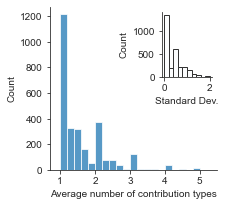

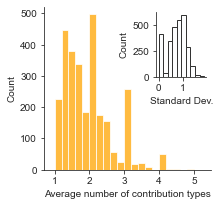

In [23]:
for data, name, color in zip([(mean_no_0_contrib_AC, std_no_0_contrib_AC),
                              (mean_no_0_contrib_OHR, std_no_0_contrib_OHR)],
                             ['ac', 'octo'],
                             clist[1:]):
    plt.figure(figsize=(3,3))
    plt.hist(data[0], color=color, alpha=0.75, bins=20)
    plt.xlim(0.7, 5.5)
    sns.despine()
    plt.ylabel('Count')
    plt.xlabel('Average number of contribution types')
      

    inset = inset_axes(plt.gca(), width="30%", height="40%", loc=1)
    inset.hist(data[1], bins=10,  facecolor=clist[0], edgecolor='#333333')
    sns.despine()
    plt.ylabel('Count')
    plt.xlabel('Standard Dev.')
    
    


### 3.1.4 Usage per language

In [24]:
main_language = [(sorted(metadata[p]['languages'], key = lambda k: metadata[p]['languages'][k], reverse=True) + ['none'])[0] for p in metadata]
while True:
    try:
        main_language.remove('none')
    except:
        break

In [25]:
Counter(main_language)

Counter({'TypeScript': 646,
         'C#': 67,
         'Ruby': 23,
         'JavaScript': 1041,
         'Shell': 52,
         'Python': 189,
         'Go': 69,
         'CSS': 42,
         'PHP': 61,
         'Kotlin': 17,
         'HTML': 103,
         'Vue': 52,
         'C++': 38,
         'Java': 66,
         'Dart': 41,
         'Swift': 14,
         'Clojure': 3,
         'C': 13,
         'Rust': 20,
         'TeX': 5,
         'Dockerfile': 9,
         'Jupyter Notebook': 33,
         'Lua': 7,
         'PowerShell': 8,
         'R': 10,
         'Blade': 3,
         'AutoHotkey': 1,
         'SCSS': 8,
         'HCL': 2,
         'TSQL': 1,
         'Vim script': 2,
         'Makefile': 8,
         'Reason': 6,
         "Ren'Py": 1,
         'Svelte': 5,
         'Groovy': 1,
         'MATLAB': 4,
         'Sass': 1,
         'Batchfile': 1,
         'Crystal': 2,
         'Erlang': 2,
         'Apex': 1,
         'Stylus': 1,
         'Haskell': 1,
         'Scala': 1,
    

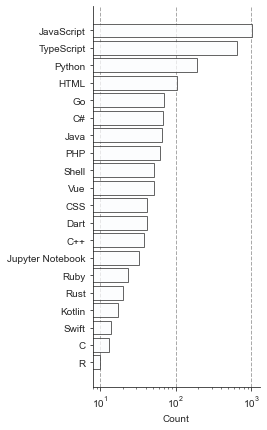

In [26]:

plt.figure(figsize=(3, 7))
idx, h= zip(*Counter(main_language).most_common(20))
plt.barh(list(reversed(idx)), list(reversed(h)), facecolor=clist[0], edgecolor="#333333", alpha=0.75)
sns.despine()
for x in [10, 100, 1000]:
    plt.axvline(x, color="#AAAAAA", ls='--', lw=1, zorder=-10)
# plt.gca().xaxis.set_ticks_position("top")
plt.gca().set_xscale('log')
# plt.gca().xaxis.set_label_position('top')
plt.xlabel('Count')
# plt.xticks(rotation=90);


### 3.1.5 Entropy

#### Base figure

In [27]:
import scipy.stats

In [28]:
def plot_entropy(db, name, color, normed=False, hl=None):
    entropy = np.zeros((len(db), 2))
    for idx, project in enumerate(db):
        credit_to_person = dict()
        credit_per_person = []
        for v in db[project]:
            credit_per_person.append(len(db[project][v][name]))
            for c in db[project][v][name]:
                try:
                    if credit_to_person.get(c) is None:
                        credit_to_person[c] = 1
                    else:
                        credit_to_person[c] += 1
                except:
                    continue
        person_per_credit = [credit_to_person[c] for c in credit_to_person]
        entropy[idx, 0] = scipy.stats.entropy(credit_per_person)
        entropy[idx, 1] = scipy.stats.entropy(person_per_credit)

        if normed:
            entropy[idx, 0] /= np.log(np.sum(credit_per_person))
            entropy[idx, 1] /= np.log(np.sum(person_per_credit))
            
    plt.scatter(entropy[:, 0], entropy[:, 1], s=5, c=color)
    plt.xlabel('Contributor entropy')
    plt.ylabel('Task entropy')
    sns.despine()
    return entropy

#### Lots of highlights:

In [33]:
def get_profile(db, metadata):
    # highlight
    highlight = [0 for i in range(len(db))]
    for idx, project in enumerate(db):
        if metadata.get(project) is not None:
            profile = metadata[project].get("profile")
            if profile is not None:
                highlight[idx] = np.sum([1 for k in profile if profile[k]])
    return highlight

def get_prop(db, metadata, prop):
    # highlight
    highlight = [0 for i in range(len(db))]
    for idx, project in enumerate(db):
        if metadata.get(project) is not None:
            highlight[idx] = metadata[project][prop]
    return np.array(highlight)

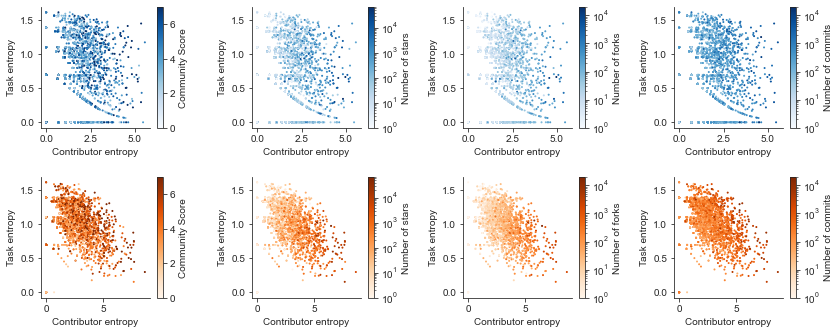

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(241)
entropy = plot_entropy(db, 'ac_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_profile(db, metadata), zorder=10, cmap=plt.cm.Blues)
plt.colorbar(label='Community Score')

plt.subplot(242)
entropy = plot_entropy(db, 'ac_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_prop(db, metadata, 'stars'), zorder=10, cmap=plt.cm.Blues, norm=LogNorm(1, 70000))
plt.colorbar(label='Number of stars')

plt.subplot(243)
entropy = plot_entropy(db, 'ac_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_prop(db, metadata, 'forks'), zorder=10, cmap=plt.cm.Blues, norm=LogNorm(1, 20000))
plt.colorbar(label='Number of forks')

plt.subplot(244)
entropy = plot_entropy(db, 'ac_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_prop(db, metadata, 'commits'), zorder=10, cmap=plt.cm.Blues, norm=LogNorm(1, 20000))
plt.colorbar(label='Number of commits')


plt.subplot(245)
entropy = plot_entropy(db, 'octo_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_profile(db, metadata), zorder=10, cmap=plt.cm.Oranges)
plt.colorbar(label='Community Score')

plt.subplot(246)
entropy = plot_entropy(db, 'octo_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_prop(db, metadata, 'stars'), zorder=10, cmap=plt.cm.Oranges, norm=LogNorm(1, 70000))
plt.colorbar(label='Number of stars')

plt.subplot(247)
entropy = plot_entropy(db, 'octo_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_prop(db, metadata, 'forks'), zorder=10, cmap=plt.cm.Oranges, norm=LogNorm(1, 20000))
plt.colorbar(label='Number of forks')

plt.subplot(248)
entropy = plot_entropy(db, 'octo_coarse', "w")
plt.scatter(entropy[:, 0], entropy[:, 1], s=1, c=get_prop(db, metadata, 'commits'), zorder=10, cmap=plt.cm.Oranges, norm=LogNorm(1, 20000))
plt.colorbar(label='Number of commits')

plt.tight_layout(pad=2)


In [36]:
print("Stars")

print("OHR, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,0]), np.log(get_prop(db, metadata, 'stars')+1)))
print("OHR, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,1]), np.log(get_prop(db, metadata, 'stars')+1)))
print("AC, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,0]), np.log(get_prop(db, metadata, 'stars')+ 1)))
print("AC, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,1]), np.log(get_prop(db, metadata, 'stars') +1)))
print("Fork")
print("OHR, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,0]), np.log(get_prop(db, metadata, 'forks')+1)))
print("OHR, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,1]), np.log(get_prop(db, metadata, 'forks')+1)))
print("AC, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,0]), np.log(get_prop(db, metadata, 'forks')+ 1)))
print("AC, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,1]), np.log(get_prop(db, metadata, 'forks') +1)))
print("commits")
print("OHR, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,0]), np.log(get_prop(db, metadata, 'commits')+1)))
print("OHR, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,1]), np.log(get_prop(db, metadata, 'commits')+1)))
print("AC, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,0]), np.log(get_prop(db, metadata, 'commits')+ 1)))
print("AC, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,1]), np.log(get_prop(db, metadata, 'commits') +1)))

Stars
OHR, contrib (0.7829650039321152, 0.0)
OHR, task (-0.29832606137133605, 1.1856032915232438e-59)
AC, contrib (0.6275924984478295, 7.19105581049e-312)
AC, task (0.14029329105159136, 5.3845041185681596e-14)
Fork
OHR, contrib (0.8784749892655036, 0.0)
OHR, task (-0.2742308056351324, 2.5241548874282367e-50)
AC, contrib (0.7188796455285431, 0.0)
AC, task (0.08431062925980498, 6.599386833023964e-06)
commits
OHR, contrib (0.5838281926946979, 5.335707335784247e-260)
OHR, task (0.019291523296357152, 0.30331583145794777)
AC, contrib (0.5585139945254738, 1.9511709861121985e-233)
AC, task (0.16767555469842693, 2.0646302008407507e-19)


In [37]:

print("OHR, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,0]), get_profile(db, metadata)))
print("OHR, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ohr[:,1]), get_profile(db, metadata)))
print("AC, contrib", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,0]), get_profile(db, metadata)))
print("AC, task", scipy.stats.pearsonr(np.nan_to_num(entropy_ac[:,1]), get_profile(db, metadata)))

OHR, contrib (0.2261919619803036, 2.2378746264980933e-34)
OHR, task (0.017543035773269985, 0.3492533055145778)
AC, contrib (0.22375681076084852, 1.1694035894810099e-33)
AC, task (0.10441883440905371, 2.3196798100913657e-08)


## 3.3 How bad is it to look only at code?

### 3.3.1 How many contributors in all-contributors don't have commits

In [38]:
# count all users that are acknowledged in all-contributors, but who don't have any commit or PR
num_ac_contrib_no_code = [len([u for u in db[project]
                               if len(db[project][u]['ac']) > 0
                               and 'code' not in db[project][u]['octo_coarse'] 
                               and not db[project][u]['tc']]
                             )
                          for project in db]

<ipython-input-39-2618c3ff986e>:2: RuntimeWarning: invalid value encountered in true_divide
  sns.displot(np.array(num_ac_contrib_no_code) / np.array(num_contrib_AC), facecolor=clist[0], edgecolor="#333333", height=3.5, aspect=0.8, bins=10)


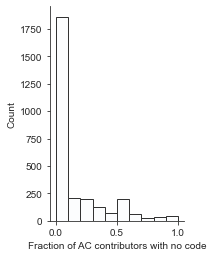

In [39]:
# Count
sns.displot(np.array(num_ac_contrib_no_code) / np.array(num_contrib_AC), facecolor=clist[0], edgecolor="#333333", height=3.5, aspect=0.8, bins=10)
sns.despine()
plt.ylabel('Count')
plt.xlabel('Fraction of AC contributors with no code');


### 3.3.1 Most missed contribution

In [40]:

ac_contrib_no_code = [[
                       db[project][u]['ac'] for u in db[project]
                       if len(db[project][u]['ac']) > 0
                       and len(db[project][u]['octo_coarse']) == 0
                       and not db[project][u]['tc']]
                       for project in db]

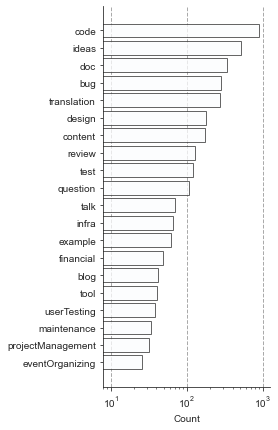

In [41]:

flattened = [c for u in ac_contrib_no_code for c in u]
flattened = [c for u in flattened for c in u]
flattened = [c for c in flattened if not isinstance(c, dict)]
# while True:
#     try:
#         flattened.remove('code')
#     except:
#         break
# Count
plt.figure(figsize=(3, 7))
idx, h= zip(*Counter(flattened).most_common(20))
plt.barh(list(reversed(idx)), list(reversed(h)), facecolor=clist[0], edgecolor="#333333", alpha=0.75)
sns.despine()
for x in [10, 100, 1000]:
    plt.axvline(x, color="#AAAAAA", ls='--', lw=1, zorder=-10)
plt.xlabel('Count')
plt.gca().set_xscale('log')


In [42]:

ac_contrib_no_code = [[
                       db[project][u]['ac'] for u in db[project]
                       if len(db[project][u]['ac']) > 0
                       and len(db[project][u]['octo_coarse']) == 0
                       and not db[project][u]['tc']]
                       for project in db]
ac_contrib = [[
               db[project][u]['ac'] for u in db[project]
               if len(db[project][u]['ac']) > 0]
               for project in db]

flattened_ac_contrib_no_code = [c for u in ac_contrib_no_code for c in u]
flattened_ac_contrib_no_code = [c for u in flattened_ac_contrib_no_code for c in u]
flattened_ac_contrib_no_code = [c for c in flattened_ac_contrib_no_code if not isinstance(c, dict)]

flattened_ac_contrib = [c for u in ac_contrib for c in u]
flattened_ac_contrib = [c for u in flattened_ac_contrib for c in u]
flattened_ac_contrib = [c for c in flattened_ac_contrib if not isinstance(c, dict)]

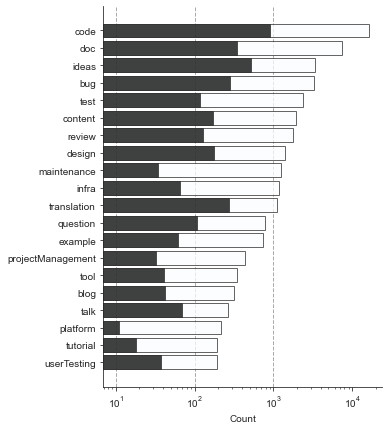

In [43]:
# Count
plt.figure(figsize=(5, 7))
idx, h= zip(*Counter(flattened_ac_contrib).most_common(20))
plt.barh(list(reversed(idx)), list(reversed(h)), facecolor=clist[0], edgecolor="#333333", alpha=0.75)
sns.despine()
for x in [10, 100, 1000]:
    plt.axvline(x, color="#AAAAAA", ls='--', lw=1, zorder=-10)
plt.xlabel('Count')
plt.gca().set_xscale('log')


counter_no_code = Counter(flattened_ac_contrib_no_code)
plt.barh(list(reversed(idx)), [counter_no_code[x] for x in list(reversed(idx))] , facecolor='k', edgecolor="#333333", alpha=0.75)



### 3.3.2  Code contributions that are not credited in all-contributors: drive by


In [44]:
# count all users that are NOT acknowledged in all-contributors, but who don't have any commit or PR
num_code_contrib_no_ac = [len([u for u in db[project]
                               if len(db[project][u]['ac']) == 0
                               and ("code" in db[project][u]['octo_coarse'] or db[project][u]['tc'])]
                             )
                          for project in db]

norm  = [len(db[project]) for project in db]

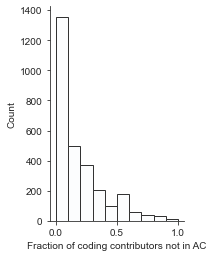

In [45]:
# Count
sns.displot(np.array(num_code_contrib_no_ac) / np.array(norm), facecolor=clist[0], edgecolor="#333333", height=3.5, aspect=0.8, bins=10)
sns.despine()
plt.ylabel('Count')
plt.xlabel('Fraction of coding contributors not in AC');


### 3.3.3 Correlations

Get dictionary of contribution types

In [46]:
contribution_types = {'top-committer'}
for p in db:
    for u in db[p]:
        for ctype in db[p][u]['octo_coarse']:
            contribution_types.add('GES:'+ctype)
        for ctype in db[p][u]['ac_coarse']:
            contribution_types.add('AC:'+ctype)
            
contribution_types = {c: idx for idx, c in enumerate(sorted(contribution_types))}
contribution_types

{'AC:artifacts': 0,
 'AC:education-outreach': 1,
 'AC:lead': 2,
 'AC:maintenance': 3,
 'AC:support': 4,
 'GES:code': 5,
 'GES:code-review': 6,
 'GES:issues': 7,
 'GES:maintenance': 8,
 'GES:wiki-docs': 9,
 'top-committer': 10}

In [47]:
def get_contigency(project, ctype):
    n = len(contribution_types)
    contigencies = np.zeros((n, n, 2, 2))
    for user in project:
        u = project[user]
        contribs = ({'AC:' + c for c in u['ac_coarse']} | {'GES:' + c for c in u['octo_coarse']} | {'top-committer' if u['tc'] else None}) - {None}
        
        for i,j in it.combinations(ctype, 2):
            contigencies[ctype[i], ctype[j], int(i in contribs), int(j in contribs)] += 1
            contigencies[ctype[j], ctype[i], int(i in contribs), int(j in contribs)] += 1
        for i in ctype:
            contigencies[ctype[i], ctype[i], int(i in contribs), int(i in contribs)] += 1
    return contigencies

In [48]:
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

def get_MI(contigency):
    n = contigency.shape[0]
    MI = np.zeros((n, n))
    for i, j in it.combinations_with_replacement(range(n), 2):
        p = np.sum(contigency[i, j], axis=0)
        p = p / np.sum(p)
        q = np.sum(contigency[i, j], axis=1)
        q = q / np.sum(q)
        pq = contigency[i, j] /np.sum(contigency[i, j])
        joint = -np.sum(np.nan_to_num(pq * np.log(pq)))
        MI[i, j] =  scipy.stats.entropy(p) + scipy.stats.entropy(q) - joint
        MI[j, i] = MI[i, j]
    return MI


In [49]:
import itertools as it

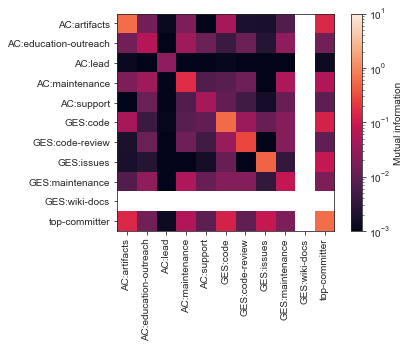

In [50]:
MI = get_MI(get_contigency(db[('all-contributors', 'all-contributors')], contribution_types))
plt.imshow(MI, origin='upper', norm=LogNorm(1e-3, 10))
plt.xticks(range(len(contribution_types)), [k for k in contribution_types], rotation=90);
plt.yticks(range(len(contribution_types)), [k for k in contribution_types]);

plt.colorbar(label='Mutual information')

Across projects

In [52]:
n = len(contribution_types)
MI = np.zeros((n, n))
for p in db:
    X = get_contigency(db[p], contribution_types)
    MI += get_MI(X)

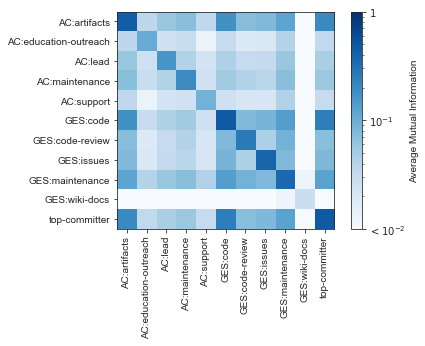

In [53]:
plt.imshow(MI / len(db), origin='upper', norm=LogNorm(1e-2, 1), cmap=plt.cm.Blues)
plt.xticks(range(len(contribution_types)), [k for k in contribution_types], rotation=90);
plt.yticks(range(len(contribution_types)), [k for k in contribution_types]);

cbar = plt.colorbar(label='Average Mutual Information', ticks=[1e-2, 1e-1, 1])
cbar.ax.set_yticklabels([r'$<10^{-2}$', '$10^{-1}$', '$1$'])  


## Others

Languages

In [54]:
languages = [(sorted(metadata[p]['languages'],  key=lambda l: metadata[p]['languages'][l], reverse=True) + ['none'])[0] for p in metadata]

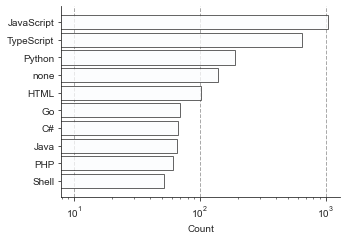

In [55]:

# Count
plt.figure(figsize=(5, 3.5))
idx, h= zip(*Counter(languages).most_common(10))
plt.barh(list(reversed(idx)), list(reversed(h)), facecolor=clist[0], edgecolor="#333333", alpha=0.75)
sns.despine()
for x in [10, 100, 1000]:
    plt.axvline(x, color="#AAAAAA", ls='--', lw=1, zorder=-10)
plt.xlabel('Count')
plt.gca().set_xscale('log')
